In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%cd "/content/drive/My Drive/Drivebox/Project/Project-COVID/CISC642-Project"
!ls

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
from datetime import datetime
import pandas as pd
import random 
from torchvision.datasets import ImageFolder
import re
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import roc_auc_score
from skimage.io import imread, imsave
import skimage
from PIL import ImageFile
from PIL import Image

torch.cuda.empty_cache()

import time

In [0]:
# Mean and std are calculated from the train dataset
normalize = transforms.Normalize(mean=[0.45271412, 0.45271412, 0.45271412],
                                     std=[0.33165374, 0.33165374, 0.33165374])
train_transformer = transforms.Compose([
    # transforms.Resize(256),
    transforms.RandomResizedCrop((256),scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size=224),
    # transforms.RandomRotation(degrees=15),
#     transforms.RandomRotation(90),
    # random brightness and random contrast
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
    # transforms.Resize(256),
    transforms.CenterCrop(size=224),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [45]:
# Load Dataset
batchsize=4
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1])}
        return sample
  
if __name__ == '__main__':
    trainset = CovidCTDataset(root_dir="Data",
                              txt_COVID="Data/Data-split/COVID/trainCT_COVID.txt",
                              txt_NonCOVID="Data/Data-split/NonCOVID/trainCT_NonCOVID.txt",
                              transform= train_transformer)
    valset = CovidCTDataset(root_dir="Data",
                              txt_COVID="Data/Data-split/COVID/valCT_COVID.txt",
                              txt_NonCOVID="Data/Data-split/NonCOVID/valCT_NonCOVID.txt",
                              transform= val_transformer)
    testset = CovidCTDataset(root_dir="Data", 
                              txt_COVID="Data/Data-split/COVID/testCT_COVID.txt",
                              txt_NonCOVID="Data/Data-split/NonCOVID/testCT_NonCOVID.txt",
                              transform= val_transformer)  
    
print(trainset.__len__())
print(valset.__len__())
print(testset.__len__())

train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

# train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
# test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

425
118
203


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


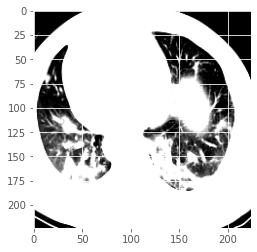

In [46]:
# plt.imshow(np.transpose(trainset.__getitem__(1)['img'].numpy(), (1, 2, 0)))

img = np.transpose(trainset.__getitem__(0)['img'].numpy(), (1, 2, 0))
plt.imshow(img); plt.show()

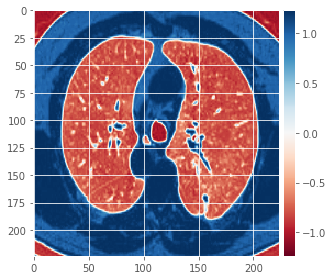

In [47]:
for batch_index, batch_samples in enumerate(train_loader):      
        data, target = batch_samples['img'], batch_samples['label']
skimage.io.imshow(data[0,1,:,:].numpy())

In [0]:
# training process

device = 'cuda'

avg_loss_train = []
avg_acc_train = []

def train(optimizer, epoch):
    
    model.train()
    
    train_loss = 0
    train_correct = 0
    

    for batch_index, batch_samples in enumerate(train_loader):
        
        # move data to device
        data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
        
        optimizer.zero_grad()
        output = model(data)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(output, target.long())

        train_loss += criteria(output, target.long())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()
    
        # Display progress and write to tensorboard
        if batch_index % bs == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_index, len(train_loader),
                100.0 * batch_index / len(train_loader), loss.item()/ bs))
    
    avg_loss_train.append(train_loss/len(train_loader.dataset))
    avg_acc_train.append(100.0 * train_correct / len(train_loader.dataset))
    
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
        100.0 * train_correct / len(train_loader.dataset)))


In [0]:
# validation process

avg_loss_val = []
avg_acc_val = []

def val(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(val_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)

            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)

            correct += pred.eq(target.long().view_as(pred)).sum().item()
            
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
        
        avg_loss_val.append(test_loss/len(val_loader.dataset))
        avg_acc_val.append(100.0 * correct / len(val_loader.dataset))

    return targetlist, scorelist, predlist

In [0]:
# test process

def test(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(test_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)

            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)

            correct += pred.eq(target.long().view_as(pred)).sum().item()
            
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
    return targetlist, scorelist, predlist


In [0]:
# training models
import torchvision.models as models

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet18":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet101":
        """ Resnet101
        """
        model_ft = models.resnet101(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "mobilenet":
        """ MobileNetV2
        """
        model_ft = models.mobilenet_v2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Linear(model_ft.last_channel, num_classes)
        input_size = 224
    
    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vgg11bn":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        # model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
    
    elif model_name == "vgg16":
        """ VGG16
        """
        # model_ft = models.vgg11_bn(pretrained=use_pretrained)
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
    
    elif model_name == "vgg16bn":
        """ VGG16bn
        """
        # model_ft = models.vgg11_bn(pretrained=use_pretrained)
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224


    # elif model_name == "inception":
    #     """ Inception v3
    #     Be careful, expects (299,299) sized images and has auxiliary output
    #     """
    #     model_ft = models.inception_v3(pretrained=use_pretrained)
    #     set_parameter_requires_grad(model_ft, feature_extract)
    #     # Handle the auxilary net
    #     num_ftrs = model_ft.AuxLogits.fc.in_features
    #     model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
    #     # Handle the primary net
    #     num_ftrs = model_ft.fc.in_features
    #     model_ft.fc = nn.Linear(num_ftrs,num_classes)
    #     input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
num_classes = 2
# feature_extract = True # freeze: only the last layer parameters are updated
feature_extract = False # the model is finetuned and all model parameters are updated

model_name = "resnet18" 
# model_name = "resnet50"
# model_name = "resnet101"
# model_name = "mobilenet"
# model_name = "densenet"
# model_name = "vgg11bn"
# model_name = "vgg16"
# model_name = "vgg16bn"
# model_name = "alexnet"
# model_name = "squeezenet"
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model = model_ft.cuda()
print(model_name)

In [0]:
# print(model)

In [0]:
# COVID-Net
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class PEXP(nn.Module):
    def __init__(self, n_input, n_out):
        super(PEXP, self).__init__()

        '''
        • First-stage Projection: 1×1 convolutions for projecting input features to a lower dimension,
        • Expansion: 1×1 convolutions for expanding features
            to a higher dimension that is different than that of the
            input features,
        • Depth-wise Representation: efficient 3×3 depthwise convolutions for learning spatial characteristics to
            minimize computational complexity while preserving
            representational capacity,
        • Second-stage Projection: 1×1 convolutions for projecting features back to a lower dimension, and
        • Extension: 1×1 convolutions that finally extend channel dimensionality to a higher dimension to produce
             the final features.
             
        '''

        self.network = nn.Sequential(nn.Conv2d(in_channels=n_input, out_channels=n_input // 2, kernel_size=1),
                                     nn.Conv2d(in_channels=n_input // 2, out_channels=int(3 * n_input / 4),
                                               kernel_size=1),
                                     nn.Conv2d(in_channels=int(3 * n_input / 4), out_channels=int(3 * n_input / 4),
                                               kernel_size=3, groups=int(3 * n_input / 4), padding=1),
                                     nn.Conv2d(in_channels=int(3 * n_input / 4), out_channels=n_input // 2,
                                               kernel_size=1),
                                     nn.Conv2d(in_channels=n_input // 2, out_channels=n_out, kernel_size=1))

    def forward(self, x):
        return self.network(x)


class CovidNet(nn.Module):
    def __init__(self, model='small', n_classes=3):
        super(CovidNet, self).__init__()
        filters = {
            'pexp1_1': [64, 256],
            'pexp1_2': [256, 256],
            'pexp1_3': [256, 256],
            'pexp2_1': [256, 512],
            'pexp2_2': [512, 512],
            'pexp2_3': [512, 512],
            'pexp2_4': [512, 512],
            'pexp3_1': [512, 1024],
            'pexp3_2': [1024, 1024],
            'pexp3_3': [1024, 1024],
            'pexp3_4': [1024, 1024],
            'pexp3_5': [1024, 1024],
            'pexp3_6': [1024, 1024],
            'pexp4_1': [1024, 2048],
            'pexp4_2': [2048, 2048],
            'pexp4_3': [2048, 2048],
        }

        self.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3))
        for key in filters:

            if ('pool' in key):
                self.add_module(key, nn.MaxPool2d(filters[key][0], filters[key][1]))
            else:
                self.add_module(key, PEXP(filters[key][0], filters[key][1]))

        if (model == 'large'):

            self.add_module('conv1_1x1', nn.Conv2d(in_channels=64, out_channels=256, kernel_size=1))
            self.add_module('conv2_1x1', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1))
            self.add_module('conv3_1x1', nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1))
            self.add_module('conv4_1x1', nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=1))

            self.__forward__ = self.forward_large_net
        else:
            self.__forward__ = self.forward_small_net
        self.add_module('flatten', Flatten())
        self.add_module('fc1', nn.Linear(7 * 7 * 2048, 1024))

        self.add_module('fc2', nn.Linear(1024, 256))
        self.add_module('classifier', nn.Linear(256, n_classes))

    def forward(self, x):
        return self.__forward__(x)

    def forward_large_net(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        out_conv1_1x1 = self.conv1_1x1(x)

        pepx11 = self.pexp1_1(x)
        pepx12 = self.pexp1_2(pepx11 + out_conv1_1x1)
        pepx13 = self.pexp1_3(pepx12 + pepx11 + out_conv1_1x1)

        out_conv2_1x1 = F.max_pool2d(self.conv2_1x1(pepx12 + pepx11 + pepx13 + out_conv1_1x1), 2)

        pepx21 = self.pexp2_1(
            F.max_pool2d(pepx13, 2) + F.max_pool2d(pepx11, 2) + F.max_pool2d(pepx12, 2) + F.max_pool2d(out_conv1_1x1,
                                                                                                       2))
        pepx22 = self.pexp2_2(pepx21 + out_conv2_1x1)
        pepx23 = self.pexp2_3(pepx22 + pepx21 + out_conv2_1x1)
        pepx24 = self.pexp2_4(pepx23 + pepx21 + pepx22 + out_conv2_1x1)

        out_conv3_1x1 = F.max_pool2d(self.conv3_1x1(pepx22 + pepx21 + pepx23 + pepx24 + out_conv2_1x1), 2)

        pepx31 = self.pexp3_1(
            F.max_pool2d(pepx24, 2) + F.max_pool2d(pepx21, 2) + F.max_pool2d(pepx22, 2) + F.max_pool2d(pepx23,
                                                                                                       2) + F.max_pool2d(
                out_conv2_1x1, 2))
        pepx32 = self.pexp3_2(pepx31 + out_conv3_1x1)
        pepx33 = self.pexp3_3(pepx31 + pepx32 + out_conv3_1x1)
        pepx34 = self.pexp3_4(pepx31 + pepx32 + pepx33 + out_conv3_1x1)
        pepx35 = self.pexp3_5(pepx31 + pepx32 + pepx33 + pepx34 + out_conv3_1x1)
        pepx36 = self.pexp3_6(pepx31 + pepx32 + pepx33 + pepx34 + pepx35 + out_conv3_1x1)

        out_conv4_1x1 = F.max_pool2d(
            self.conv4_1x1(pepx31 + pepx32 + pepx33 + pepx34 + pepx35 + pepx36 + out_conv3_1x1), 2)

        pepx41 = self.pexp4_1(
            F.max_pool2d(pepx31, 2) + F.max_pool2d(pepx32, 2) + F.max_pool2d(pepx32, 2) + F.max_pool2d(pepx34,
                                                                                                       2) + F.max_pool2d(
                pepx35, 2) + F.max_pool2d(pepx36, 2) + F.max_pool2d(out_conv3_1x1, 2))
        pepx42 = self.pexp4_2(pepx41 + out_conv4_1x1)
        pepx43 = self.pexp4_3(pepx41 + pepx42 + out_conv4_1x1)
        flattened = self.flatten(pepx41 + pepx42 + pepx43 + out_conv4_1x1)

        fc1out = F.relu(self.fc1(flattened))
        fc2out = F.relu(self.fc2(fc1out))
        logits = self.classifier(fc2out)
        return logits

    def forward_small_net(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)

        pepx11 = self.pexp1_1(x)
        pepx12 = self.pexp1_2(pepx11)
        pepx13 = self.pexp1_3(pepx12 + pepx11)

        pepx21 = self.pexp2_1(F.max_pool2d(pepx13, 2) + F.max_pool2d(pepx11, 2) + F.max_pool2d(pepx12, 2))
        pepx22 = self.pexp2_2(pepx21)
        pepx23 = self.pexp2_3(pepx22 + pepx21)
        pepx24 = self.pexp2_4(pepx23 + pepx21 + pepx22)

        pepx31 = self.pexp3_1(
            F.max_pool2d(pepx24, 2) + F.max_pool2d(pepx21, 2) + F.max_pool2d(pepx22, 2) + F.max_pool2d(pepx23, 2))
        pepx32 = self.pexp3_2(pepx31)
        pepx33 = self.pexp3_3(pepx31 + pepx32)
        pepx34 = self.pexp3_4(pepx31 + pepx32 + pepx33)
        pepx35 = self.pexp3_5(pepx31 + pepx32 + pepx33 + pepx34)
        pepx36 = self.pexp3_6(pepx31 + pepx32 + pepx33 + pepx34 + pepx35)

        pepx41 = self.pexp4_1(
            F.max_pool2d(pepx31, 2) + F.max_pool2d(pepx32, 2) + F.max_pool2d(pepx32, 2) + F.max_pool2d(pepx34,
                                                                                                       2) + F.max_pool2d(
                pepx35, 2) + F.max_pool2d(pepx36, 2))
        pepx42 = self.pexp4_2(pepx41)
        pepx43 = self.pexp4_3(pepx41 + pepx42)
        flattened = self.flatten(pepx41 + pepx42 + pepx43)

        fc1out = F.relu(self.fc1(flattened))
        fc2out = F.relu(self.fc2(fc1out))
        logits = self.classifier(fc2out)
        return logits

In [0]:
# # Load COVID-Net
# model = CovidNet()
# ckpoint = torch.load("/content/drive/My Drive/Drivebox/Project/Project-COVID/CISC642-Project/model/COVIDNet_large_best_checkpoint.pth.tar")
# model = model.cuda()
# # print(model)

# # # Freeze Mode
# # for param in model.parameters():
# #     param.requires_grad = False
# # 
# # fc1_inputs = model.fc1.in_features
# # model.fc1 = nn.Sequential(
# #     nn.Linear(fc1_inputs, 1024),
# #     nn.ReLU(),
# #     nn.Dropout(0.4),
# #     nn.Linear(1024, 2),
# #     nn.LogSoftmax(dim=1) # For using NLLLoss()
# # )

# # fc2_inputs = model.fc2.in_features
# # model.fc2 = nn.Sequential(
# #     nn.Linear(fc2_inputs, 256),
# #     nn.ReLU(),
# #     nn.Dropout(0.4),
# #     nn.Linear(256, 2),
# #     nn.LogSoftmax(dim=1) # For using NLLLoss()
# # )
# # model = model.cuda()

In [55]:
# train
bs =batchsize
votenum = 10
import warnings
warnings.filterwarnings('ignore')

r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(valset.__len__())
vote_score = np.zeros(valset.__len__())

#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
                                             
scheduler = StepLR(optimizer, step_size=1)

total_epoch = 10
for epoch in range(1, total_epoch+1):
    train(optimizer, epoch)
    
    targetlist, scorelist, predlist = val(epoch)
    print('target',targetlist)
    print('score',scorelist)
    print('predict',predlist)
    vote_pred = vote_pred + predlist 
    vote_score = vote_score + scorelist 

    if epoch % votenum == 0:
        
        vote_pred[vote_pred <= (votenum/2)] = 0
        vote_pred[vote_pred > (votenum/2)] = 1
        vote_score = vote_score/votenum
        
        print('vote_pred', vote_pred)
        print('targetlist', targetlist)
        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()
        
        
        print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
        print('TP+FP',TP+FP)
        p = TP / (TP + FP)
        print('precision',p)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        print('recall',r)
        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)
        print('F1',F1)
        print('acc',acc)
        AUC = roc_auc_score(targetlist, vote_score)
        print('AUCp', roc_auc_score(targetlist, vote_pred))
        print('AUC', AUC)
        
        vote_pred = np.zeros(valset.__len__())
        vote_score = np.zeros(valset.__len__())
        print('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))


Train Epoch: 1 [0/107 (0%)]	Train Loss: 0.191860
Train Epoch: 1 [4/107 (4%)]	Train Loss: 0.188920
Train Epoch: 1 [8/107 (7%)]	Train Loss: 0.107534
Train Epoch: 1 [12/107 (11%)]	Train Loss: 0.186518
Train Epoch: 1 [16/107 (15%)]	Train Loss: 0.185193
Train Epoch: 1 [20/107 (19%)]	Train Loss: 0.146983
Train Epoch: 1 [24/107 (22%)]	Train Loss: 0.067852
Train Epoch: 1 [28/107 (26%)]	Train Loss: 0.126078
Train Epoch: 1 [32/107 (30%)]	Train Loss: 0.044026
Train Epoch: 1 [36/107 (34%)]	Train Loss: 0.186178
Train Epoch: 1 [40/107 (37%)]	Train Loss: 0.150406
Train Epoch: 1 [44/107 (41%)]	Train Loss: 0.106679
Train Epoch: 1 [48/107 (45%)]	Train Loss: 0.072500
Train Epoch: 1 [52/107 (49%)]	Train Loss: 0.339465
Train Epoch: 1 [56/107 (52%)]	Train Loss: 0.082531
Train Epoch: 1 [60/107 (56%)]	Train Loss: 0.088619
Train Epoch: 1 [64/107 (60%)]	Train Loss: 0.158754
Train Epoch: 1 [68/107 (64%)]	Train Loss: 0.287783
Train Epoch: 1 [72/107 (67%)]	Train Loss: 0.140615
Train Epoch: 1 [76/107 (71%)]	Train L

In [56]:
# test
bs = 10
import warnings
warnings.filterwarnings('ignore')

epoch = 1
r_list = []
p_list = []
acc_list = []
AUC_list = []

vote_pred = np.zeros(testset.__len__())
vote_score = np.zeros(testset.__len__())


targetlist, scorelist, predlist = test(epoch)
print('target',targetlist)
print('score',scorelist)
print('predict',predlist)
vote_pred = vote_pred + predlist 
vote_score = vote_score + scorelist 

TP = ((predlist == 1) & (targetlist == 1)).sum()

TN = ((predlist == 0) & (targetlist == 0)).sum()
FN = ((predlist == 0) & (targetlist == 1)).sum()
FP = ((predlist == 1) & (targetlist == 0)).sum()

print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
print('TP+FP',TP+FP)
p = TP / (TP + FP)
print('precision',p)
p = TP / (TP + FP)
r = TP / (TP + FN)
print('recall',r)
F1 = 2 * r * p / (r + p)
acc = (TP + TN) / (TP + TN + FP + FN)
print('F1',F1)
print('acc',acc)
AUC = roc_auc_score(targetlist, vote_score)
print('AUC', AUC)


target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.14818051 0.91387832 0.79719532 0.31883606 0.7892589  0.13544877
 0.48553383 0.24778892 0.06329724 0.14700568 0.05149914 0.09681097
 0.14768316 0.96782076 0.95755577 0.97075886 0.20361809 0.11732347
 0.11677307 0.78229845 0.1014766  0.15166393 0.86701322 0.09601334
 0.36393338 0.37651986 0.12903675 0.65977794 0.98235267 0.88099915
 0.83399212 0.9538421  0.96124685

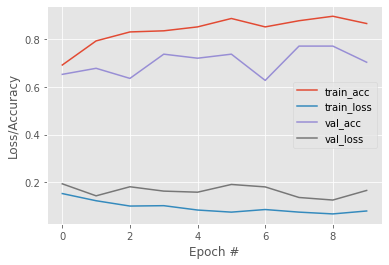

In [57]:
# Learning Curve
N = total_epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), np.array(avg_acc_train[:10])*0.01, label="train_acc")
plt.plot(np.arange(0, N), avg_loss_train[:10], label="train_loss")
plt.plot(np.arange(0, N), np.array(avg_acc_val)*0.01, label="val_acc")
plt.plot(np.arange(0, N), avg_loss_val, label="val_loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()